In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pyshtools as pysh
import RFmod as RF
import SLmod as SL
import xarray as xr
import slsolver as sls

from numpy import pi as pi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
## Preliminaries

L = 64
lmax=50
Q = RF.sobolev_covariance(L, s=2, mu=0.2)
rhow = SL.rhow
b = SL.b
g = SL.g

# read in the present day sea level and ice thickness
sl0,ice0 = SL.get_sl_ice_data(L)
C = SL.ocean_function(sl0,ice0)

In [40]:
## For the input to our function, we would like a vector formed by reshaping a gridded direct load, zeta

zeta_glq = -rhow*RF.random_field(Q)
zeta_gr = zeta_glq.to_array()
zeta_vec = zeta_gr.reshape(-1)

zeta_alt_glq = -rhow*RF.random_field(Q)

In [80]:
## Function that computes the inner product of the solution to the fingerprint problem and the adjoint load

def inner_product_quadruple(fingerprint_solution_quadruple, adjoint_load_quadruple):

    ## Unpack the quadruples
    sl, u, phi, om = fingerprint_solution_quadruple
    zeta_d, zeta_u_d, zeta_phi_d, kk_d = adjoint_load_quadruple
    
    return  SL.surface_integral(sl*zeta_d) + SL.surface_integral(u*zeta_u_d) \
       + SL.surface_integral(phi*zeta_phi_d) - np.inner(kk_d,om)/g

## SLSolver testing

In [24]:
import importlib
importlib.reload(sls)

<module 'slsolver' from '/raid/dah94/SLpy/slsolver.py'>

In [557]:
importlib.reload(SL)

<module 'SLmod' from '/raid/dah94/SLpy/SLmod.py'>

In [41]:
A = sls.GraceSolver(L, lmax)

In [42]:
test = A.solve_fingerprint(zeta_glq)
test_phi_vec = A.observation_operator(test)

test_sol = A.solve_fingerprint(zeta_alt_glq)

#### Test (P\*test_sol,v) against (test_sol,P.T*v)


In [78]:
## Want to test (P*test_sol,v) against (test_sol,P.T*v)

## LHS

print(np.dot(A.observation_operator(test_sol), test_phi_vec))

## RHS

print(SL.surface_integral(test_sol[2]*A.observation_operator_adjoint(test_phi_vec)[2])/(g*b**2))

0.044747453200016434
0.057229083879126265


In [81]:
inner_product_quadruple(test_sol[0:4], A.observation_operator_adjoint(test_phi_vec))/(g*b**2)

0.057229083879126265

#### Test (A\*zeta, phi') against (zeta, A.T\*phi')

In [82]:
## LHS

Azeta = A.solve_fingerprint(zeta_glq)
phi_prime = A.solve_fingerprint(zeta_alt_glq)
print(SL.surface_integral(Azeta[2]*phi_prime[2])/b**2)

## Other way of doing LHS (sum over coeefficients)

print(np.dot(A.observation_operator(Azeta),A.observation_operator(phi_prime)))

## RHS

zeta = zeta_glq
zeta_phi_d = A.observation_operator_adjoint(A.observation_operator(phi_prime))[2]
null = zeta_phi_d - zeta_phi_d
ATphi = A.solve_adjoint_fingerprint(null, null, zeta_phi_d, [0,0])
print(SL.surface_integral(zeta*ATphi[2])/b**2)


0.5623123034229467
0.044747453200016434
-14.675814096977845


(<Figure size 640x352 with 1 Axes>,
 <Axes: xlabel='GLQ longitude index', ylabel='GLQ latitude index'>)

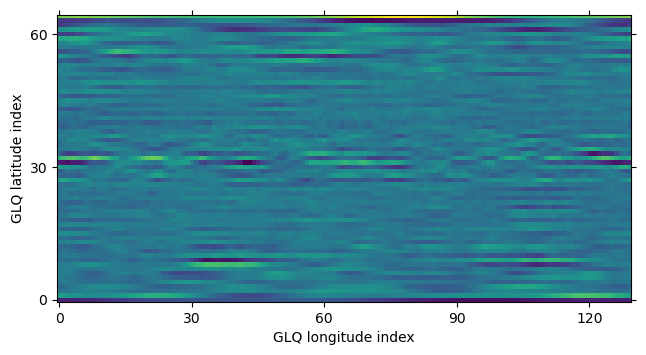

In [38]:
## Test to see if expand actually works
original_gridded_data = zeta_glq
expanded_coefficients = original_gridded_data.expand().to_array()
reconstructed_gridded_data = pysh.SHGrid.from_array(pysh.expand.MakeGridGLQ(expanded_coefficients, extend=1), grid='GLQ')

## Plot the difference field
(reconstructed_gridded_data - original_gridded_data).plot()

## Obviously this doesn't quite apply to our case, as we are truncating the coefficients 2 <= l <= lmax

In [83]:
## Now let's look at the code which reshapes the vector of coefficients into an array

## As above:
original_gridded_data = zeta_glq
expanded_coefficients = original_gridded_data.expand().to_array()

## Now we need to reshape into a vector, like in the real function. 
## This is the bit that truncates it
vector_of_coefficients = expanded_coefficients[:,2:lmax+1,:lmax+1].reshape(-1)

## Now do the pseudo-reverse (not full reverse due to the truncation)
reconstructed_coefficients = np.zeros([2,lmax+1,lmax+1])
reconstructed_coefficients[:,2:lmax+1,:lmax+1] = vector_of_coefficients.reshape(2,lmax-1,lmax+1)

reconstructed_coefficients - expanded_coefficients[:,0:lmax+1,0:lmax+1]

## Seems to be working well!


array([[[ 204.65869031,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [-252.01118405,  -69.89574007,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        ...,
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ]],

       [[   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,  -60.80059532,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.

(<Figure size 640x352 with 1 Axes>,
 <Axes: xlabel='GLQ longitude index', ylabel='GLQ latitude index'>)

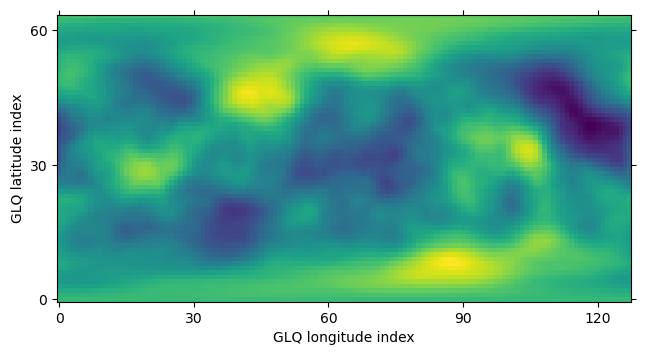

In [12]:
Azeta[2].plot()

In [13]:
A.observation_operator_adjoint(A.observation_operator(A.solve_fingerprint(A.vector_to_grid(zeta_vec))))

(kind = 'real'
 grid = 'GLQ'
 nlat = 64
 nlon = 128
 lmax = 63
 units = None
 extend = True,
 kind = 'real'
 grid = 'GLQ'
 nlat = 64
 nlon = 128
 lmax = 63
 units = None
 extend = True,
 kind = 'real'
 grid = 'GLQ'
 nlat = 64
 nlon = 128
 lmax = 63
 units = None
 extend = True,
 array([0, 0]))

In [14]:
test = A.solve_fingerprint(A.vector_to_grid(zeta_vec))
test1 = A.observation_operator(test)
test2 = A.observation_operator_adjoint(test1)

In [15]:
## Compare the two ways of expanding SH coefficients

print(pysh.expand.SHExpandGLQ(test[2].to_array())[0,:3,:3])
print('')
print(test[2].expand().to_array()[0,:3,:3])

[[-0.00082515  0.          0.        ]
 [-0.00042387 -0.00200243  0.        ]
 [ 0.14189135 -0.13336959 -0.14273107]]

[[ 1.48275007e-16  0.00000000e+00  0.00000000e+00]
 [-3.62212395e-18  3.87550542e-17  0.00000000e+00]
 [ 1.40847198e-01 -1.37901336e-01 -1.43656669e-01]]


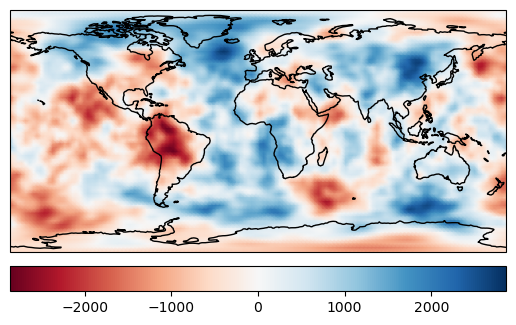

In [ ]:
A.plot_from_grid(A.vector_to_grid(zeta_vec))

(<Figure size 640x352 with 1 Axes>,
 <Axes: xlabel='GLQ longitude index', ylabel='GLQ latitude index'>)

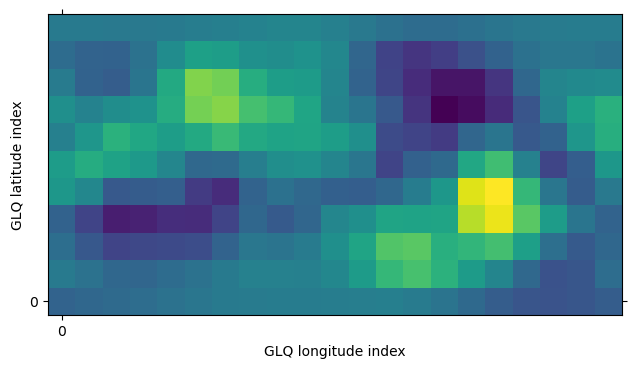

In [ ]:
pysh.SHGrid.from_array(pysh.expand.MakeGridGLQ(coeffs,lmax_calc=lmax),grid='GLQ').plot()

## CODE BIN

In [ ]:
## Code which ordered the SH coefficients nicely

coeffs_vec = np.zeros(((self.observation_degree+1)**2)-4)       
for l in range(2,self.observation_degree+1):
    coeffs_vec[((l)**2)-4:((l+1)**2)-4] = np.concatenate((phi_coeffs[1,l,1:l+1][::-1],phi_coeffs[0,l,0:l+1]))

## And the other way round

phi_coeffs = np.zeros((2,self.truncation_degree+1,self.truncation_degree+1))
## For reference: Clm = phi_coeffs[0,l,m>=0] and Slm = phi_coeffs[1,l,m>=1]
for l in range(2,self.observation_degree+1):
    phi_coeffs[1,l,1:l+1] = phi_coeffs_vec[(l**2)-4:(l**2)-4+l][::-1]
    phi_coeffs[0,l,0:l+1] = phi_coeffs_vec[(l**2)-4+l:((l+1)**2)-4]

## The action of A

In [ ]:
## Version of the function which just uses a normal GLQRealGrid as input

def potential0(zeta_glq, L, lmax=10):

    ## Solve the sea level equation
    _,_,solution,_,_ = SL.fingerprint(C, zeta_glq)

    ## Expand the solution in spherical harmonics. Clm = solution[0,l,m] and Slm = solution[1,l,m]
    coeffs = pysh.expand.SHExpandGLQ(solution.to_array(),lmax_calc=lmax)

    ## Populate a vector (1-D np array) with the expanded coefficients, in ascending order of l (2<=l<=lmax), doing Clm in reverse order then Slm in standard order for each l
    coeffs_vec = np.zeros(((lmax+1)**2)-4)
    
    for l in range(2,lmax+1):
        coeffs_vec[((l)**2)-4:((l+1)**2)-4] = np.concatenate((coeffs[1,l,1:l+1][::-1],coeffs[0,l,0:l+1]))
    
    return coeffs_vec

In [ ]:
## Full version of the function

def potential(zeta_vec, L, lmax=10):

    ## Convert zeta to a GLQGrid
    zeta_glq = pysh.SHGrid.from_array(zeta_vec.reshape(L+1,2*(L+1)),grid='GLQ')

    ## Solve the sea level equation
    _,_,solution,_,_ = SL.fingerprint(C, zeta_glq)

    ## Expand the solution in spherical harmonics. Clm = solution[0,l,m] and Slm = solution[1,l,m]
    coeffs = pysh.expand.SHExpandGLQ(solution.to_array(),lmax_calc=lmax)

    ## Populate a vector (1-D np array) with the expanded coefficients, in ascending order of l (2<=l<=lmax), doing Clm in reverse order then Slm in standard order for each l
    coeffs_vec = np.zeros(((lmax+1)**2)-4)
    
    for l in range(2,lmax+1):
        coeffs_vec[((l)**2)-4:((l+1)**2)-4] = np.concatenate((coeffs[1,l,1:l+1][::-1],coeffs[0,l,0:l+1]))
    
    return coeffs_vec


## The action of A* on an arbitray vector, phi'

In [ ]:
## First make an arbitrary field, phi'

phi_glq = RF.random_field(Q)
phi_gr = phi_glq.to_array()
phi_vec = phi_gr.reshape(-1)

def potential_adjoint(phi_vec, L, lmax=10):

    ## Convert phi to a GLQGrid
    phi_glq = pysh.SHGrid.from_array(phi_vec.reshape(L+1,2*(L+1)),grid='GLQ')

    ## Define a null vector (representing phi_d and phu_u_d)
    null = phi_glq - phi_glq

    ## Find zeta_phi_d by scaling phi with -g/b^2, where b is the radius of the earth
    zeta_phi_d = -SL.g/SL.b**2*phi_glq

    ## Then find k_d
    kk_d = SL.rotation_vector_from_zeta_psi(zeta_phi_d)

    ## Now solve the adjoint fingerprint problem
    sl_d,_,_,_,_ = SL.generalised_fingerprint(C,null, null, zeta_phi_d, kk_d)

    ## Expand the solution in spherical harmonics. Clm = solution[0,l,m] and Slm = solution[1,l,m]
    coeffs = pysh.expand.SHExpandGLQ(sl_d.to_array(),lmax_calc=lmax)

    ## Populate a vector (1-D np array) with the expanded coefficients, in ascending order of l (2<=l<=lmax), doing Clm in reverse order then Slm in standard order for each l
    coeffs_vec = np.zeros(((lmax+1)**2)-4)
    
    for l in range(2,lmax+1):
        coeffs_vec[((l)**2)-4:((l+1)**2)-4] = np.concatenate((coeffs[1,l,1:l+1][::-1],coeffs[0,l,0:l+1]))
    
    return coeffs_vec

## Testing the adjoint function
potential_adjoint(phi_vec, L)


iteration =  1 relative change =  0.21478994116614647
iteration =  2 relative change =  0.050525227422862286
iteration =  3 relative change =  0.012591232527893393
iteration =  4 relative change =  0.003270738384465201
iteration =  5 relative change =  0.000882994577367237
iteration =  6 relative change =  0.0002468053670298152
iteration =  7 relative change =  7.114971644994906e-05
iteration =  8 relative change =  2.1076112562494505e-05
iteration =  9 relative change =  6.386740569453724e-06
iteration =  10 relative change =  1.9709668571757502e-06
iteration =  11 relative change =  6.168785257932412e-07
iteration =  12 relative change =  1.9513049933928618e-07
iteration =  13 relative change =  6.221189190889611e-08
iteration =  14 relative change =  1.994809916175029e-08
iteration =  15 relative change =  6.4221768631441684e-09


array([ 1.28056400e-18, -3.42515484e-18, -5.87000841e-18,  2.66874428e-17,
        4.29028677e-18,  1.21863495e-18, -1.37426820e-18, -2.42982812e-19,
       -3.04492481e-19, -1.27821124e-18, -6.45359818e-19,  7.21430820e-20,
        9.85871703e-19,  1.65675670e-18, -1.50557240e-18,  3.87278387e-20,
       -1.31364616e-18,  1.29332374e-18, -2.29130322e-18, -1.69978428e-18,
        7.94846500e-19,  1.47644045e-18, -2.72280948e-19, -1.08620870e-18,
       -1.85934615e-19, -2.58419172e-18, -1.43399725e-18, -2.92602557e-19,
        1.17025429e-18, -1.22342677e-19,  1.30534576e-18,  9.06219163e-19,
       -9.96852817e-22, -9.85522300e-19, -1.21505117e-18,  1.36176364e-19,
       -3.81982200e-19,  1.04710606e-18, -1.14653234e-18, -1.10825095e-20,
        6.14479263e-19, -3.58424479e-19,  5.82195386e-19,  1.01599624e-18,
       -2.82430632e-19, -2.31135407e-19,  2.88175905e-20, -5.25160344e-20,
       -2.09398462e-19,  3.73512880e-19, -1.16624529e-18,  2.81905749e-19,
        5.80592400e-19, -

In [ ]:
class SeaLevelSolver:


    def __init__(self, truncation_degree):
        self.truncation_degree = truncation_degree
        self.current_sea_level, self.current_ice_thickness = SL.get_sl_ice_data(truncation_degree)
        self.ocean_function = SL.ocean_function(self.current_sea_level, self.current_ice_thickness)

    def solve_fingerprint(self, zeta_glq):

        return SL.fingerprint(self.ocean_function, zeta_glq)
    
    def solve_adjoint_fingerprint(self, zeta_d, zeta_u_d, zeta_phi_d, kk_d):

        return SL.generalised_fingerprint(self.ocean_function, zeta_d, zeta_u_d, zeta_phi_d, kk_d)
    
    def grid_to_vector(self, grid):
        ## Converts GLQGrid to a vector
        return grid.to_array().reshape(-1)
        
    def vector_to_grid(self, vector):
        ## Converts vector to GLQGrid
        return pysh.SHGrid.from_array(vector.reshape([HELP]+1,2*(L+1)),grid='GLQ')
        
    def plot_from_grid(self, grid):
        ## Plots a GLQGrid
        SL.plot(grid)
        

class GraceSolver(SeaLevelSolver):


    def __init__(self, truncation_degree, observation_degree ):
        super().__init__(truncation_degree)
        self.observation_degree = observation_degree

    def solve_for_grace_coefficients(self,zeta):

        return self.solve_fingerprint(zeta)

    def observation_operator(self, solution):

        coeffs = pysh.expand.SHExpandGLQ(solution[2].to_array(),lmax_calc=self.observation_degree)
        coeffs_vec = np.zeros(((self.observation_degree+1)**2)-4)
        for l in range(2,self.observation_degree+1):
            coeffs_vec[((l)**2)-4:((l+1)**2)-4] = np.concatenate((coeffs[1,l,1:l+1][::-1],coeffs[0,l,0:l+1]))
        return coeffs_vec
    
    def __matmul__(self,zeta_vector):
        return self.observation_operator(self.solve_for_grace_coefficients(self.vector_to_grid(zeta_vector)))

